In [513]:
import datetime
import pandas as pd

from calculator.util import preprocess_table

SEP_DATE = datetime.date(2022, 6, 1)

table, num_columns, real_series = preprocess_table(pd.read_csv(f'../download_data/data/hour_candles/SBER.csv'))
table.shape

(30956, 49)

In [514]:
table_train = table[table.index < SEP_DATE]
table_val = table[table.index > SEP_DATE]

KeyboardInterrupt: 

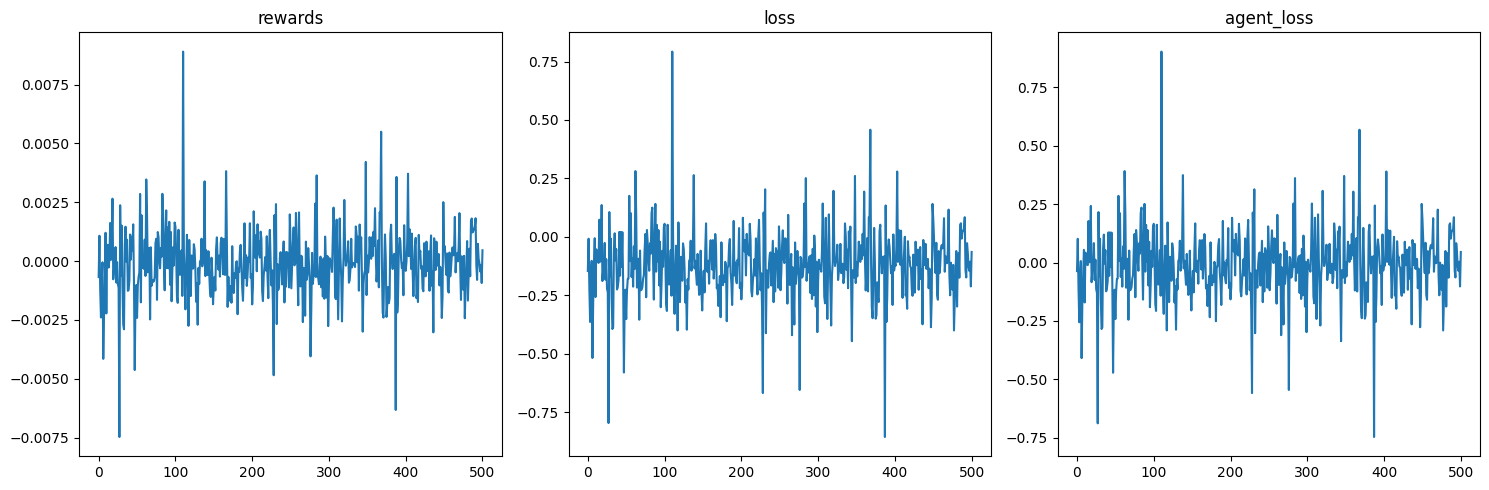

In [517]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

from calculator.stats import moving_average
from algo.transform import CastLists, ReinforceValues
from algo.reinforce import ReinforceEnv, ReinforceAgent, Reinforce
from algo.runner import EnvRunner


NUMBER_TRAJECTORIES = 1000
gamma = 0.99
T = 1000

env = ReinforceEnv(table_train)
agent = ReinforceAgent(state_length=len(env.reset()), action_length=3)

optimizer = torch.optim.Adam(agent.model.parameters(), lr=1e-2)

algo = Reinforce(agent, optimizer, env, entropy_coef=0.1)
runner = EnvRunner(env, agent, T, transformers=[ReinforceValues(gamma), CastLists()])

for i in range(NUMBER_TRAJECTORIES):
    trajectory = runner.get_next()
    algo.step(trajectory)

    if i % 10 == 0:
        clear_output(True)
        plt.gcf().set_size_inches(15, 5)
        for index, label in enumerate(["rewards", "loss", "agent_loss"]):
            plt.subplot(1, 3, index + 1)
            plt.title(label)
            values = env.get_values(label)
            plt.plot(values)
        plt.tight_layout()
        plt.savefig('reinforce')
        plt.show()

In [518]:
np.corrcoef(env.get_values('rewards'), env.get_values('loss'))

array([[1.        , 0.97074939],
       [0.97074939, 1.        ]])

In [519]:
agent.get_action(torch.tensor(table_val.iloc[1000][env.num_columns], dtype=torch.float32))

{'actions': tensor([0]),
 'probs': tensor([0.3349, 0.3185, 0.3466], grad_fn=<SoftmaxBackward0>),
 'log_probs': tensor([-1.0938, -1.1442, -1.0596], grad_fn=<LogSoftmaxBackward0>)}

In [520]:
agent.get_action(torch.tensor(table_train.iloc[10000][env.num_columns], dtype=torch.float32))

{'actions': tensor([0]),
 'probs': tensor([0.3349, 0.3185, 0.3466], grad_fn=<SoftmaxBackward0>),
 'log_probs': tensor([-1.0938, -1.1442, -1.0596], grad_fn=<LogSoftmaxBackward0>)}

Mean action = 2.000


ValueError: x and y must have same first dimension, but have shapes (3200,) and (3210,)

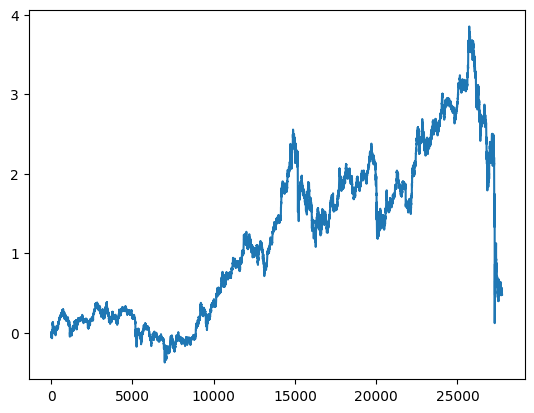

In [521]:
from calculator.util import return_revenue

plot_step = 1000
env = ReinforceEnv(table)
dates = pd.to_datetime(env.table.index).date
sum_rewards, actions = return_revenue(env, agent)
print(f'Mean action = {np.mean(actions):.3f}')
plt.plot(np.arange(len(table_train)), sum_rewards[:len(table_train)], label='Train')
plt.plot(np.arange(len(table_train), len(table_train) + len(table_val)), sum_rewards[len(table_train):], label='Valid')
plt.xticks(range(0, len(table), plot_step), labels=dates[range(0, len(table), plot_step)], rotation=70)
plt.plot(np.arange(len(table)), real_series - 1, label='Real Series')
plt.legend();

In [747]:
from pathlib import Path

names = []
for filename in Path('../download_data/data/hour_candles/').iterdir():
    with open(filename) as file:
        if len(file.readlines()) > 30000:
            names.append(filename.name)
len(names)

11

In [504]:
import pandas as pd
from pathlib import Path
from calculator.util import preprocess_several

USE_VOLATILITY = True
SEP_DATETIME = datetime.datetime(2022, 6, 1)
EXCLUDE_DATETIME = {datetime.datetime(2015, 1, 20, hour=i) for i in range(24)}  # remove corrupted data

set_indexes = None
tables = []
for filename in names:
    table = pd.read_csv(f'../download_data/data/hour_candles/{filename}')
    table, num_columns, set_indexes = preprocess_several(table, use_vol=USE_VOLATILITY, set_indexes=set_indexes)
    tables.append(table)

set_indexes = sorted(set_indexes - EXCLUDE_DATETIME)
for index in range(len(tables)):
    tables[index] = tables[index].loc[set_indexes].sort_index()

tables_train = [table[table.index < SEP_DATETIME] for table in tables]
tables_val = [table[table.index >= SEP_DATETIME] for table in tables]

assert np.array([(tables_train[0].index == tables_train[i].index).all() for i in range(len(tables_train))]).all()

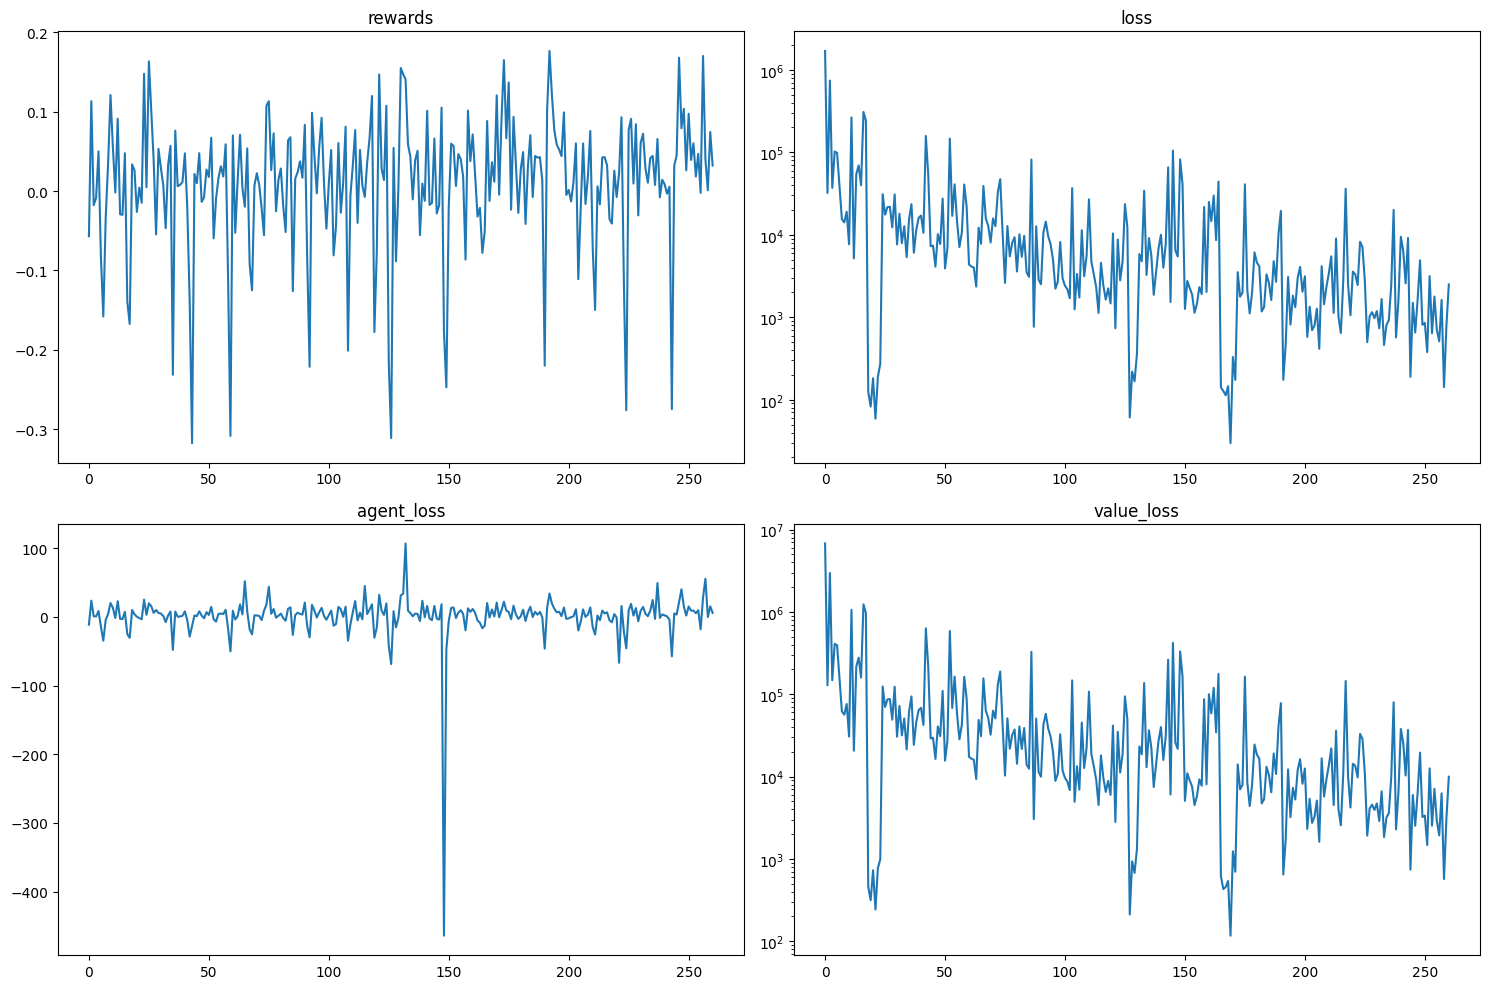

KeyboardInterrupt: 

In [700]:
from algo.a2c import A2CEnv, A2CAgent, A2C, Net
from algo.transform import A2CValues

NUMBER_TRAJECTORIES = 1000
gamma = 0.99
T = 1000
EXPERIMENT_NUMBER = 13

env = A2CEnv(tables_train)
net = Net(input_shape=len(env.reset()), action_shape=len(names), hidden_size=64)
agent = A2CAgent(net)

optimizer = torch.optim.Adam(agent.model.parameters(), lr=1e-3)

algo = A2C(agent, optimizer, env)
runner = EnvRunner(env, agent, T, transformers=[A2CValues(agent, gamma, predict_all=False), CastLists()])

for i in range(NUMBER_TRAJECTORIES):
    trajectory = runner.get_next()
    algo.step(trajectory)

    if i % 2 == 0:
        clear_output(True)
        plt.gcf().set_size_inches(15, 10)
        for index, label in enumerate(["rewards", "loss", "agent_loss", "value_loss"]):
            plt.subplot(2, 2, index + 1)
            plt.title(label)
            values = env.get_values(label)
            plt.plot(values)
            if label in ['loss', 'value_loss'] and np.min(values) > 0:
                plt.yscale('log')
        plt.tight_layout()
        plt.savefig('a2c')
        plt.show()

In [701]:
from calculator.util import several_revenue

plot_step = 1000
test_env = A2CEnv(tables)
dates = pd.to_datetime(env.tables[0].index).date
sum_rewards, means = several_revenue(test_env, agent)

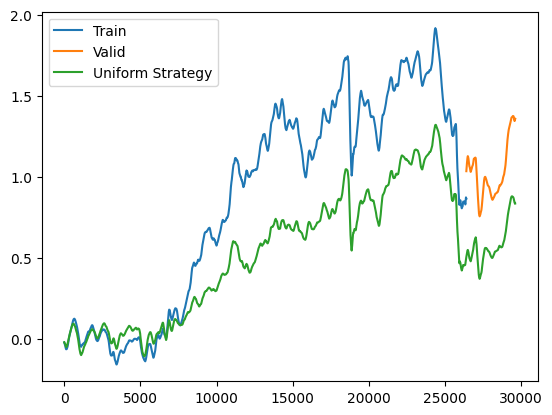

In [704]:
length = 200
plt.plot(np.arange(len(tables_train[0])), moving_average(sum_rewards[:len(tables_train[0])], length), label='Train')
plt.plot(np.arange(len(tables_train[0]), len(tables_train[0]) + len(tables_val[0])), moving_average(sum_rewards[len(tables_train[0]):], length), label='Valid')
plt.plot(np.arange(len(tables[0])), moving_average(means, length), label='Uniform Strategy')
plt.legend()
# plt.savefig('../pictures/third_a2c/comp')

In [705]:
compare_df = pd.DataFrame(columns=["Strategy", "Mean Return", "Std Return", "Series Std"])
rew_pct, means_pct = pd.Series(sum_rewards).pct_change().iloc[2:], pd.Series(means).pct_change().iloc[2:]
compare_df.loc[0] = ["Agent", rew_pct.mean(), rew_pct.std(), sum_rewards.std()]
compare_df.loc[1] = ["Uniform", means_pct.mean(), means_pct.std(), means.std()]
compare_df

,Strategy,Mean Return,Std Return,Series Std
0,Agent,-0.006198,2.812334,0.615597
1,Uniform,0.048410,10.222372,0.380871


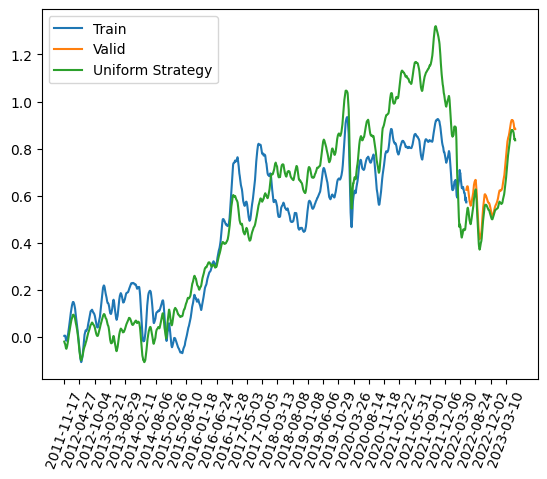

In [396]:
length = 200
plt.plot(np.arange(len(tables_train[0])), moving_average(sum_rewards[:len(tables_train[0])], length), label='Train')
plt.plot(np.arange(len(tables_train[0]), len(tables_train[0]) + len(tables_val[0])), moving_average(sum_rewards[len(tables_train[0]):], length), label='Valid')
plt.plot(np.arange(len(tables[0])), moving_average(means, length), label='Uniform Strategy')
plt.xticks(range(0, len(tables[0]), plot_step), labels=dates[range(0, len(tables[0]), plot_step)], rotation=70)
plt.legend();

In [404]:
compare_df = pd.DataFrame(columns=["Strategy", "Mean Return", "Std Return", "Series Std"])
rew_pct, means_pct = pd.Series(sum_rewards).pct_change().iloc[2:], pd.Series(means).pct_change().iloc[2:]
compare_df.loc[0] = ["Agent", rew_pct.mean(), rew_pct.std(), sum_rewards.std()]
compare_df.loc[1] = ["Uniform", means_pct.mean(), means_pct.std(), means.std()]
compare_df

,Strategy,Mean Return,Std Return,Series Std
0,Agent,-0.003358,2.694469,0.296030
1,Uniform,0.048410,10.222372,0.380871


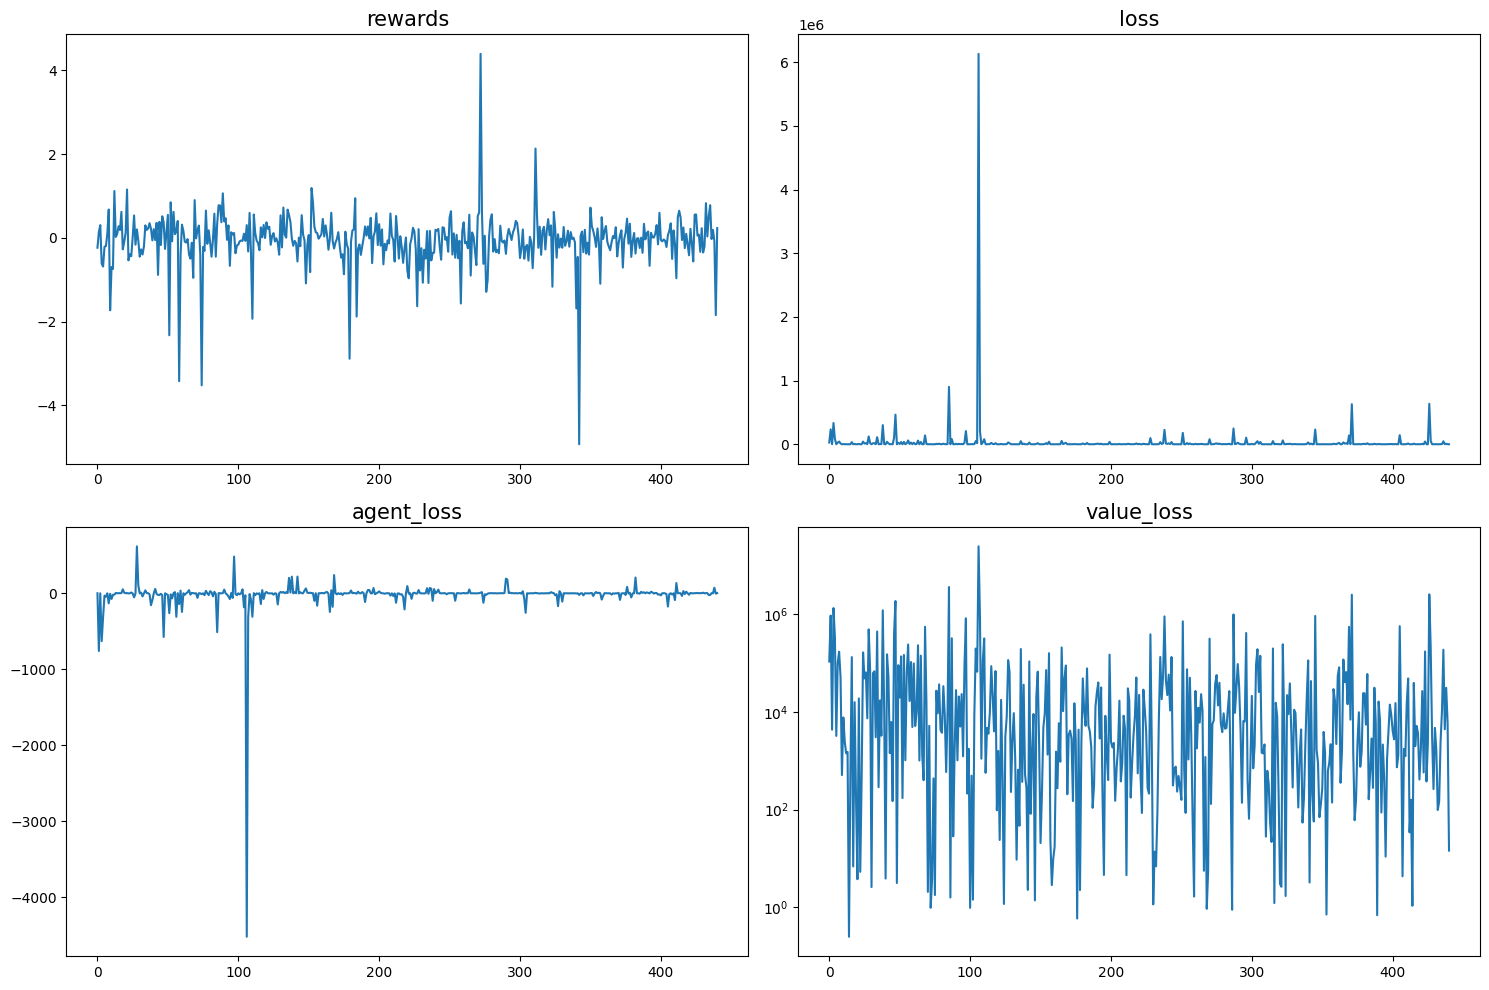

In [748]:
from algo.ddpg import DDPGEnv, DDPGFirstAgent, DDPGSecondAgent, DDPG
from algo.transform import SampleBuffer, DDPGValues

NUMBER_TRAJECTORIES = 100000
gamma = 0.99
T = 1000
BATCH_SIZE = 16
EXPERIMENT_NUMBER = 21

env = DDPGEnv(tables_train)
first_net = Net(input_shape=len(env.reset()), action_shape=len(names), hidden_size=64)
second_net = Net(input_shape=len(env.reset()), action_shape=len(names), hidden_size=64)
second_net.load_state_dict(first_net.state_dict())

first_agent = DDPGFirstAgent(first_net)
second_agent = DDPGSecondAgent(second_net, tau=0.5)

optimizer = torch.optim.Adam(first_agent.model.parameters(), lr=1e-3)

algo = DDPG(first_agent, second_agent, optimizer, env)
runner = EnvRunner(env, first_agent, T, transformers=[CastLists(), SampleBuffer(BATCH_SIZE), DDPGValues(gamma, second_agent)])

for i in range(NUMBER_TRAJECTORIES):
    trajectory = runner.get_next()
    algo.step(trajectory)

    if i % 5 == 0:
        clear_output(True)
        plt.gcf().set_size_inches(15, 10)
        for index, label in enumerate(["rewards", "loss", "agent_loss", "value_loss"]):
            plt.subplot(2, 2, index + 1)
            plt.title(label, fontsize=15)
            values = env.get_values(label)
            plt.plot(values)
            if label in ['loss', 'value_loss'] and np.min(values) > 0:
                plt.yscale('log')
        plt.tight_layout()
        plt.savefig('ddpg')
        plt.show()

In [749]:
test_env = DDPGEnv(tables)
dates = pd.to_datetime(test_env.tables[0].index).date
sum_rewards, means = several_revenue(test_env, first_agent)

In [753]:
first_agent.get_action(env.reset())

In [754]:
plt.plot(np.arange(len(tables_train[0])), moving_average(sum_rewards[:len(tables_train[0])], length), label='Train')
plt.plot(np.arange(len(tables_train[0]), len(tables_train[0]) + len(tables_val[0])), moving_average(sum_rewards[len(tables_train[0]):], length), label='Valid')
plt.plot(np.arange(len(tables[0])), moving_average(means, length), label='Uniform Strategy')
plt.xticks(range(0, len(tables[0]), plot_step), labels=dates[range(0, len(tables[0]), plot_step)], rotation=70)
plt.legend()

In [752]:
compare_df = pd.DataFrame(columns=["Strategy", "Mean Return", "Std Return", "Series Std"])
rew_pct, means_pct = pd.Series(sum_rewards).pct_change().iloc[2:], pd.Series(means).pct_change().iloc[2:]
compare_df.loc[0] = ["Agent", rew_pct.mean(), rew_pct.std(), sum_rewards.std()]
compare_df.loc[1] = ["Uniform", means_pct.mean(), means_pct.std(), means.std()]
compare_df